<a href="https://colab.research.google.com/github/kvan493/MSDS462_FinalProject/blob/main/MSDS462_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import numpy as np
import pandas as pd
import glob
import pathlib

import tensorflow as tf
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback,EarlyStopping

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

## Data Ingestion

### Importing in training, validation, and testing files

In [28]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#Importing images from files
data = DataLoader.from_folder('/content/drive/MyDrive/archive (3)/train')
dirlist = [item for item in os.listdir('/content/drive/MyDrive/archive (3)/train') if os.path.isdir(os.path.join('/content/drive/MyDrive/archive (3)/train', item)) ]
print(dirlist)

INFO:tensorflow:Load image with size: 43622, num_label: 300, labels: AFRICAN CROWNED CRANE, AFRICAN FIREFINCH, ALBATROSS, ALEXANDRINE PARAKEET, AMERICAN AVOCET, AMERICAN BITTERN, AMERICAN COOT, AMERICAN GOLDFINCH, AMERICAN KESTREL, AMERICAN PIPIT, AMERICAN REDSTART, ANHINGA, ANNAS HUMMINGBIRD, ANTBIRD, ARARIPE MANAKIN, ASIAN CRESTED IBIS, BALD EAGLE, BALD IBIS, BALI STARLING, BALTIMORE ORIOLE, BANANAQUIT, BANDED BROADBILL, BANDED PITA, BAR-TAILED GODWIT, BARN OWL, BARN SWALLOW, BARRED PUFFBIRD, BAY-BREASTED WARBLER, BEARDED BARBET, BEARDED BELLBIRD, BEARDED REEDLING, BELTED KINGFISHER, BIRD OF PARADISE, BLACK & YELLOW bROADBILL, BLACK FRANCOLIN, BLACK SKIMMER, BLACK SWAN, BLACK TAIL CRAKE, BLACK THROATED BUSHTIT, BLACK THROATED WARBLER, BLACK VULTURE, BLACK-CAPPED CHICKADEE, BLACK-NECKED GREBE, BLACK-THROATED SPARROW, BLACKBURNIAM WARBLER, BLONDE CRESTED WOODPECKER, BLUE GROUSE, BLUE HERON, BOBOLINK, BORNEAN BRISTLEHEAD, BORNEAN LEAFBIRD, BORNEAN PHEASANT, BROWN CREPPER, BROWN NOODY, B

### Creating labels.txt file

In [30]:
#Obtaining labels for each bird species from folder names and creating the text file for labels
f = open("labels.txt","w+")

for i in dirlist:
  f.write('%s\n' % i)
f.close()


### Obtaining all directory/subdirectory for all images

In [31]:
#Function to obtain the file paths for eaach image
def img_processing(data):
  path=pathlib.Path(data)

  #Going through all the subpaths 
  filepaths=list(path.glob(r"*/*.jpg"))

  #Separating the label from file path and storing it in dataframe
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
  df1=pd.Series(filepaths,name='filepaths').astype(str)
  df2=pd.Series(labels,name='labels')
  df=pd.concat([df1,df2],axis=1)
  return df

In [32]:
#Obtaining dataframe of all file paths for each image along with the proper labels for training, validation and test sets
train = '/content/drive/MyDrive/archive (3)/train'
valid = '/content/drive/MyDrive/archive (3)/valid'
test = '/content/drive/MyDrive/archive (3)/test'

train_df = img_processing(train)
valid_df = img_processing(valid)
test_df = img_processing(test)

In [33]:
#Viewing the training data frame
train_df

,filepaths,labels
0,/content/drive/MyDrive/archive (3)/train/YELLO...,YELLOW HEADED BLACKBIRD
1,/content/drive/MyDrive/archive (3)/train/YELLO...,YELLOW HEADED BLACKBIRD
2,/content/drive/MyDrive/archive (3)/train/YELLO...,YELLOW HEADED BLACKBIRD
3,/content/drive/MyDrive/archive (3)/train/YELLO...,YELLOW HEADED BLACKBIRD
4,/content/drive/MyDrive/archive (3)/train/YELLO...,YELLOW HEADED BLACKBIRD
...,...,...
43617,/content/drive/MyDrive/archive (3)/train/AMERI...,AMERICAN AVOCET
43618,/content/drive/MyDrive/archive (3)/train/AMERI...,AMERICAN AVOCET
43619,/content/drive/MyDrive/archive (3)/train/AMERI...,AMERICAN AVOCET
43620,/content/drive/MyDrive/archive (3)/train/AMERI...,AMERICAN AVOCET


## Data Visualization

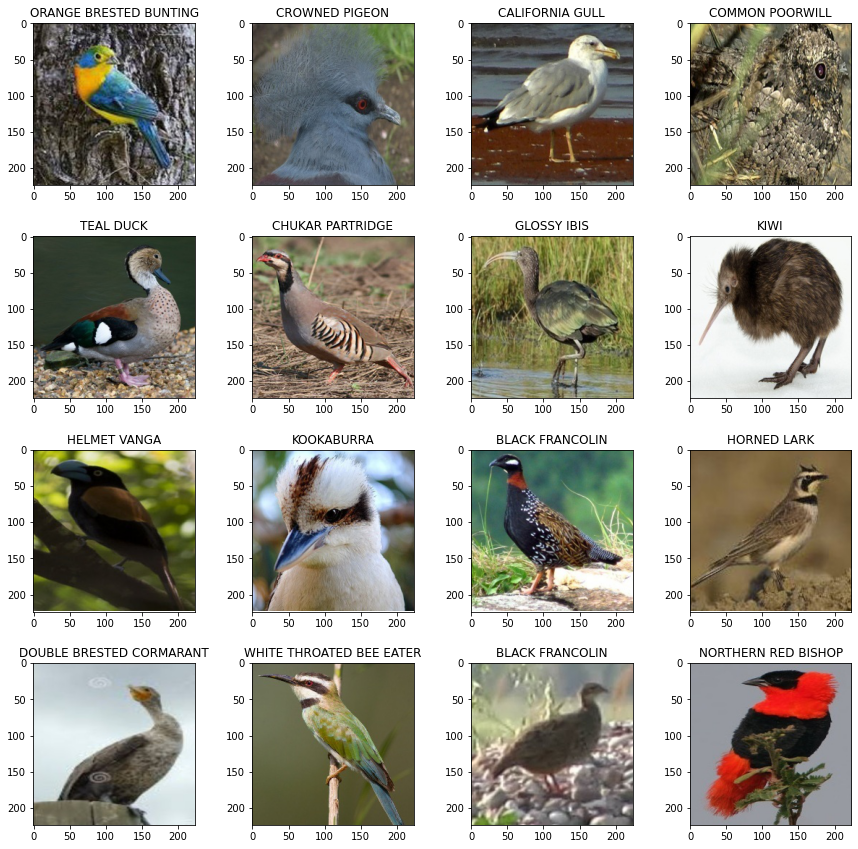

In [34]:
#Viewing random images of birds
train_df = train_df.sample(frac=1).reset_index(drop=True)
fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(12,12))

for i,ax in enumerate(axes.flat):
    x=plt.imread(train_df['filepaths'][i])
    ax.imshow(x)
    ax.set_title(train_df['labels'][i])
plt.tight_layout()    
plt.show() 

## Data Preprocessing

In [35]:
#Preprocessing data for training, validation, and test sets
datagen = ImageDataGenerator(rescale=1. / 255)

train = datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(100,100),
    batch_size=32)

val= datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(100,100),
    batch_size=32)

test = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(100,100),
    batch_size=32)

Found 43622 validated image filenames belonging to 300 classes.
Found 1500 validated image filenames belonging to 300 classes.
Found 1500 validated image filenames belonging to 300 classes.


### Model

In [36]:
#Getting ResNet50 model and freezing the top layers
modified = tf.keras.applications.resnet50.ResNet50(include_top = False, 
                                                   input_shape = (100, 100,3), 
                                                   pooling = "avg",
                                                   weights='imagenet')

#Function for modifying adding layers to original ResNet50 model 
def create_model():
    model = keras.models.Sequential([
        modified,
        keras.layers.Dense(120, activation = 'relu'),
        keras.layers.Dense(300, activation='softmax')
    ])


    #model.layers[0].trainable = False
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
    return model


model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 120)               245880    
                                                                 
 dense_3 (Dense)             (None, 300)               36300     
                                                                 
Total params: 23,869,892
Trainable params: 23,816,772
Non-trainable params: 53,120
_________________________________________________________________


In [37]:
#Setting features for early stopping
early_stop  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=3,
                              mode='auto')]

In [38]:
#Fitting the model
final_model = model.fit(train,
                        validation_data=val,
                        epochs=15,
                        callbacks= early_stop)

final_model

Epoch 1/15
1364/1364 [==============================] - 137s 97ms/step - loss: 3.9353 - accuracy: 0.1694 - val_loss: 3.6713 - val_accuracy: 0.3293
Epoch 2/15
1364/1364 [==============================] - 131s 96ms/step - loss: 2.0020 - accuracy: 0.4991 - val_loss: 1.4719 - val_accuracy: 0.6220
Epoch 3/15
1364/1364 [==============================] - 131s 96ms/step - loss: 1.3051 - accuracy: 0.6588 - val_loss: 1.1694 - val_accuracy: 0.6853
Epoch 4/15
1364/1364 [==============================] - 132s 97ms/step - loss: 0.9193 - accuracy: 0.7501 - val_loss: 1.1799 - val_accuracy: 0.6893
Epoch 5/15
1364/1364 [==============================] - 132s 96ms/step - loss: 0.6449 - accuracy: 0.8155 - val_loss: 0.9451 - val_accuracy: 0.7667
Epoch 6/15
1364/1364 [==============================] - 132s 97ms/step - loss: 0.4512 - accuracy: 0.8651 - val_loss: 1.0942 - val_accuracy: 0.7207
Epoch 7/15
1364/1364 [==============================] - 131s 96ms/step - loss: 0.3273 - accuracy: 0.8999 - val_loss: 1

### Exporting and saving the Model

In [42]:
model.save("model.h5", include_optimizer=False)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpspw7xv31/assets


In [ ]:
# model = image_classifier.create(train_data)

### Viewing the accuracy and loss 
performance of training and validation sets

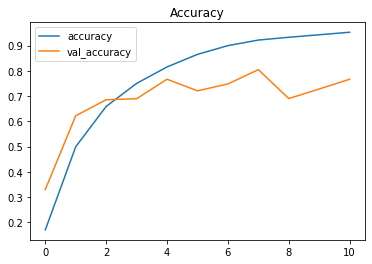

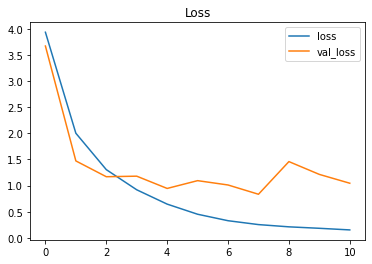

In [45]:
pd.DataFrame(final_model.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(final_model.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [49]:
model.predict(test)

array([[2.89683413e-07, 1.55998379e-04, 9.34708805e-06, ...,
        1.34157069e-11, 8.97813698e-11, 5.65445220e-08],
       [8.25687293e-19, 1.87740613e-18, 3.23124478e-18, ...,
        1.16766708e-24, 4.56180535e-21, 1.33367777e-13],
       [1.17447035e-12, 1.58328341e-15, 5.67935083e-15, ...,
        7.46957218e-10, 2.53287096e-11, 2.13349765e-07],
       ...,
       [8.60140003e-14, 2.04960864e-17, 1.10418246e-13, ...,
        6.26267024e-11, 1.50161966e-11, 7.64950386e-13],
       [3.74967923e-09, 2.98952500e-07, 2.36819517e-07, ...,
        1.08884818e-10, 2.23918605e-12, 3.42429090e-08],
       [4.98939311e-21, 2.24411483e-20, 2.48032409e-21, ...,
        6.44680977e-14, 1.43589176e-08, 1.16650419e-07]], dtype=float32)

In [48]:
test